In [1]:
import pandas as pd
import matplotlib.pyplot as plt

logs = # TO FILL
graph_dir = f"{logs}/graphs/accuracy"
processed_log_dir = f"{logs}/resultats_11-23_processed"
log_dir = f"{logs}/resultats_11-23/"
save_dir = f"{processed_log_dir}/rnnt/"
path = f"{log_dir}/rnnt/"

job_file = save_dir+"/summary.csv"
energy_file = save_dir+"/energy.csv"
jobs = pd.read_csv(job_file).drop(columns=["Unnamed: 0"])

In [2]:
jobs.columns

Index(['job', 'energy_kWh', 'energy_joule',
       'energy_consumption_since_previous_measurement_milliJ', 'job_id',
       'file', 'sub_seed', 'srun_start_time_ms', 'start_time_ms',
       'training_start_time_ms', 'cmd_batch_size', 'cmd_beta1', 'cmd_beta2',
       'cmd_max_duration', 'cmd_val_batch_size', 'cmd_target', 'cmd_lr',
       'cmd_min_lr', 'cmd_lr_exp_gamma', 'cmd_epochs', 'cmd_warmup_epochs',
       'cmd_hold_epochs', 'cmd_epochs_this_job', 'cmd_ema', 'cmd_model_config',
       'cmd_dataset_dir', 'cmd_weight_decay', 'cmd_log_frequency',
       'cmd_val_frequency', 'cmd_grad_accumulation_steps',
       'cmd_prediction_frequency', 'cmd_weights_init_scale',
       'cmd_val_manifests', 'cmd_num_buckets', 'cmd_max_symbol_per_sample',
       'cmd_apex_transducer_loss', 'cmd_apex_transducer_joint', 'cmd_fc_impl',
       'cmd_ema_update_type', 'train_end_time_ms', 'end_time_ms', 'epoch_nb',
       'block_nb', 'eval_nb', 'mllog_seed',
       'mllog_gradient_accumulation_steps', 'ml

In [3]:
cols = ['mllog_eval_accuracy','energy_kWh','node_nb',  'mllog_gradient_accumulation_steps','block_nb', 
        'mllog_train_samples', 
        'eval_nb',
        'mllog_global_batch_size',
        'mllog_opt_base_learning_rate',
       'mllog_eval_samples', 
        ]
cols = [x for x in jobs.columns if jobs[x].dtype != "object"]
pd.set_option('display.max_colwidth', 15)
pd.set_option('display.max_rows', 67)
jobs[cols].style.background_gradient(cmap='viridis', low=0.2, high=0.2, axis=0)

,job,energy_kWh,energy_joule,energy_consumption_since_previous_measurement_milliJ,job_id,sub_seed,srun_start_time_ms,start_time_ms,training_start_time_ms,cmd_batch_size,cmd_beta1,cmd_beta2,cmd_max_duration,cmd_val_batch_size,cmd_target,cmd_lr,cmd_min_lr,cmd_lr_exp_gamma,cmd_epochs,cmd_warmup_epochs,cmd_hold_epochs,cmd_epochs_this_job,cmd_ema,cmd_weight_decay,cmd_log_frequency,cmd_val_frequency,cmd_grad_accumulation_steps,cmd_prediction_frequency,cmd_weights_init_scale,cmd_num_buckets,cmd_max_symbol_per_sample,train_end_time_ms,end_time_ms,epoch_nb,block_nb,eval_nb,mllog_seed,mllog_gradient_accumulation_steps,mllog_model_weights_initialization_scale,mllog_eval_max_prediction_symbols,mllog_model_eval_ema_factor,mllog_data_train_max_duration,mllog_data_speed_perturbaton_max,mllog_data_speed_perturbaton_min,mllog_data_spec_augment_freq_n,mllog_data_spec_augment_freq_min,mllog_data_spec_augment_freq_max,mllog_data_spec_augment_time_n,mllog_data_spec_augment_time_min,mllog_data_spec_augment_time_max,mllog_global_batch_size,mllog_data_train_num_buckets,mllog_train_samples,mllog_eval_samples,mllog_opt_base_learning_rate,mllog_opt_lamb_epsilon,mllog_opt_lamb_learning_rate_decay_poly_power,mllog_opt_learning_rate_warmup_epochs,mllog_opt_lamb_learning_rate_hold_epochs,mllog_opt_lamb_beta_1,mllog_opt_lamb_beta_2,mllog_opt_gradient_clip_norm,mllog_opt_learning_rate_alt_decay_func,mllog_opt_learning_rate_alt_warmup_func,mllog_opt_lamb_learning_rate_min,mllog_opt_weight_decay,mllog_throughput,mllog_eval_accuracy,node_nb
0,126701,2.153195,7751502.051876,7751502051.875732,126701,51,1699463890000.000000,1699463894000.000000,1699463894000.000000,192,0.900000,0.999000,16.700000,338,0.058000,0.007200,0.000010,0.920000,80,5,26,0,0.995000,0.001000,1000,1,1,1000000,0.500000,1,300,1699466286000.000000,1699466289000.000000,54,54,54,52,1,0.500000,300,0.995000,16.700000,1.150000,0.850000,2,0,20,10,0,0.030000,1536,1,278016,2703,0.007200,0.000000,0.920000,5,26,0.900000,0.999000,1,True,True,0.000010,0.001000,6804.870687,0.057884,1
1,126702,2.122240,7640062.883321,7640062883.321045,126702,51,1699466417000.000000,1699466420000.000000,1699466420000.000000,192,0.900000,0.999000,16.700000,338,0.058000,0.007200,0.000010,0.920000,80,5,26,0,0.995000,0.001000,1000,1,1,1000000,0.500000,1,300,1699468729000.000000,1699468732000.000000,54,54,54,52,1,0.500000,300,0.995000,16.700000,1.150000,0.850000,2,0,20,10,0,0.030000,1536,1,278016,2703,0.007200,0.000000,0.920000,5,26,0.900000,0.999000,1,True,True,0.000010,0.001000,6632.345663,0.057884,1
2,126703,2.141938,7710976.879772,7710976879.771728,126703,51,1699468860000.000000,1699468863000.000000,1699468863000.000000,192,0.900000,0.999000,16.700000,338,0.058000,0.007200,0.000010,0.920000,80,5,26,0,0.995000,0.001000,1000,1,1,1000000,0.500000,1,300,1699471213000.000000,1699471216000.000000,54,54,54,52,1,0.500000,300,0.995000,16.700000,1.150000,0.850000,2,0,20,10,0,0.030000,1536,1,278016,2703,0.007200,0.000000,0.920000,5,26,0.900000,0.999000,1,True,True,0.000010,0.001000,6139.446273,0.057884,1
3,126704,2.116881,7620770.788037,7620770788.036621,126704,51,1699471344000.000000,1699471347000.000000,1699471347000.000000,192,0.900000,0.999000,16.700000,338,0.058000,0.007200,0.000010,0.920000,80,5,26,0,0.995000,0.001000,1000,1,1,1000000,0.500000,1,300,1699473649000.000000,1699473652000.000000,54,54,54,52,1,0.500000,300,0.995000,16.700000,1.150000,0.850000,2,0,20,10,0,0.030000,1536,1,278016,2703,0.007200,0.000000,0.920000,5,26,0.900000,0.999000,1,True,True,0.000010,0.001000,6677.898366,0.057884,1
4,126705,2.122413,7640685.067901,7640685067.901367,126705,51,1699473786000.000000,1699473790000.000000,1699473790000.000000,192,0.900000,0.999000,16.700000,338,0.058000,0.007200,0.000010,0.920000,80,5,26,0,0.995000,0.001000,1000,1,1,1000000,0.500000,1,300,1699476100000.000000,1699476103000.000000,54,54,54,52,1,0.500000,300,0.995000,16.700000,1.150000,0.850000,2,0,20,10,0,0.030000,1536,1,278016,2703,0.007200,0.000000,0.920000,5,26,0.900000,0.9990

In [4]:
jobs["duration(minutes)"] = (jobs["end_time_ms"] - jobs["start_time_ms"])/60/1000

In [6]:
cols=['cmd_learning_rate', 'cmd_max_steps']
gp_by = ["node_nb", "sub_seed"] # mllog_train_samples mllog_d_batch_size sub_batch-size sub_num-sample
jobs.groupby(gp_by).count()["job_id"]

node_nb  sub_seed
1        6           4
         7           4
         42          4
         51          5
Name: job_id, dtype: int64

In [7]:
(jobs["energy_kWh"].max()-jobs["energy_kWh"].min())/jobs["energy_kWh"].max()
# diff de 5% entre le max et le min

0.13290471109676272

/Users/mathildepro/miniforge3/envs/energy_analysis/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x800 with 0 Axes>

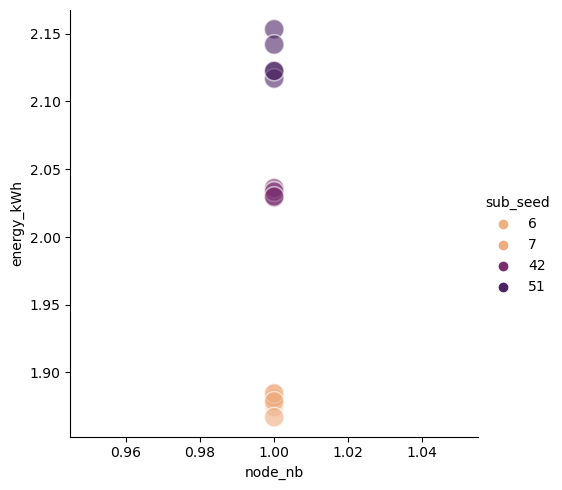

In [8]:
# mllog_train_samples mllog_d_batch_size sub_batch-size sub_num-sample
import seaborn as sns
plt.figure(figsize=(15,8))
sns.relplot(
    data=jobs,
    x="node_nb", y="energy_kWh", hue="sub_seed", s=200, alpha=0.6, palette="flare"
)

/Users/mathildepro/miniforge3/envs/energy_analysis/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x800 with 0 Axes>

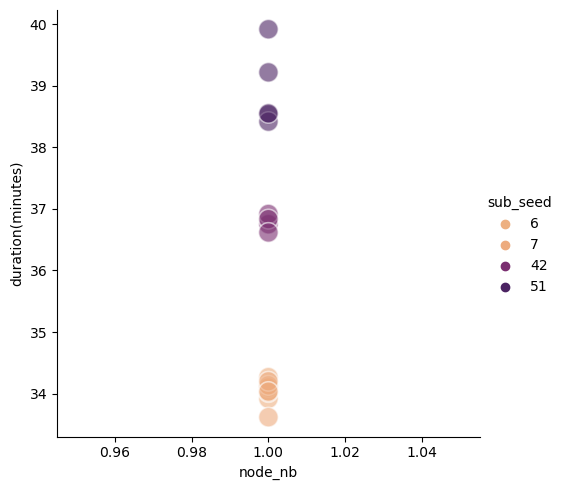

In [9]:
# mllog_train_samples mllog_d_batch_size sub_batch-size sub_num-sample
import seaborn as sns
plt.figure(figsize=(15,8))
sns.relplot(
    data=jobs,
    x="node_nb", y="duration(minutes)", hue="sub_seed", s=200, alpha=0.6, palette="flare"
)

# MLLOGS

In [10]:
list(jobs.job)

[126701,
 126702,
 126703,
 126704,
 126705,
 126706,
 126707,
 126708,
 126709,
 126710,
 126711,
 126712,
 126713,
 126714,
 126715,
 126716,
 126717]

In [11]:
plot_df = jobs[(jobs["job"]==126701)]

file = plot_df.file.values[0]
file.split("/")[-2:]

log_file = path + "/".join(file.split("/")[-2:])
print(log_file)


/Users/mathildepro/Documents/code_projects/hpe_logs/resultats_nov/rnnt/126701/231108181721312636982_1.log


In [13]:

import sys
sys.path.append("../../logging/mlperf_logging/")
from compliance_checker.mlp_parser import parse_file
loglines, _ = parse_file(log_file, ruleset="2.1.0")
mllog = pd.DataFrame(loglines)
mllog

,full_string,timestamp,key,value,lineno
0,":::MLLOG {""...",1.699464e+12,init_start,{'value': N...,0
1,":::MLLOG {""...",1.699464e+12,init_start,{'value': N...,1
2,":::MLLOG {""...",1.699464e+12,init_start,{'value': N...,2
3,":::MLLOG {""...",1.699464e+12,init_start,{'value': N...,3
4,":::MLLOG {""...",1.699464e+12,init_start,{'value': N...,4
...,...,...,...,...,...
481,":::MLLOG {""...",1.699466e+12,eval_start,{'value': N...,481
482,":::MLLOG {""...",1.699466e+12,eval_accuracy,{'value': 0...,482
483,":::MLLOG {""...",1.699466e+12,eval_stop,{'value': N...,483
484,":::MLLOG {""...",1.699466e+12,block_stop,{'value': N...,484


In [14]:
def get_value(row):
    """Get key value pairs from mllog rows."""
    for key, value in row['metadata'].items():
        row["meta_"+key] = value
    return row

mllog['metadata'] = mllog.apply(lambda row: row['value']['metadata'], axis=1)
mllog['value'] = mllog.apply(lambda row: row['value']['value'], axis=1)
mllog = mllog.apply(get_value, axis=1)


In [15]:
mllog[-20:]

,full_string,key,lineno,meta_epoch_count,meta_epoch_num,meta_file,meta_first_epoch_num,meta_lineno,meta_status,meta_tensor,metadata,timestamp,value
466,":::MLLOG {""...",eval_accuracy,466,NaN,52.0,train.py,NaN,262,NaN,NaN,{'file': 't...,1.699466e+12,0.059079
467,":::MLLOG {""...",eval_stop,467,NaN,52.0,train.py,NaN,263,NaN,NaN,{'file': 't...,1.699466e+12,None
468,":::MLLOG {""...",block_stop,468,NaN,NaN,train.py,52.0,972,NaN,NaN,{'file': 't...,1.699466e+12,None
469,":::MLLOG {""...",block_start,469,1.0,NaN,train.py,53.0,830,NaN,NaN,{'file': 't...,1.699466e+12,None
470,":::MLLOG {""...",epoch_start,470,NaN,53.0,train.py,NaN,833,NaN,NaN,{'file': 't...,1.699466e+12,None
471,":::MLLOG {""...",epoch_stop,471,NaN,53.0,train.py,NaN,944,NaN,NaN,{'file': 't...,1.699466e+12,None
472,":::MLLOG {""...",throughput,472,NaN,NaN,train.py,NaN,951,NaN,NaN,{'file': 't...,1.699466e+12,6580.99663
473,":::MLLOG {""...",eval_start,473,NaN,53.0,train.py,NaN,242,NaN,NaN,{'file': 't...,1.699466e+12,None
474,":::MLLOG {""...",eval_accuracy,474,NaN,53.0,train.py,NaN,262,NaN,NaN,{'file': 't...,1.699466e+12,0.058123
475,":::MLLOG {""...",eval_stop,475,NaN,53.0,train.py,NaN,263,NaN,NaN,{'file': 't...,1.699466e+12,None


In [21]:
mllog[~mllog["value"].isna()].key.describe()

count               144
unique               38
top       eval_accuracy
freq                 54
Name: key, dtype: object

<Axes: xlabel='timestamp'>

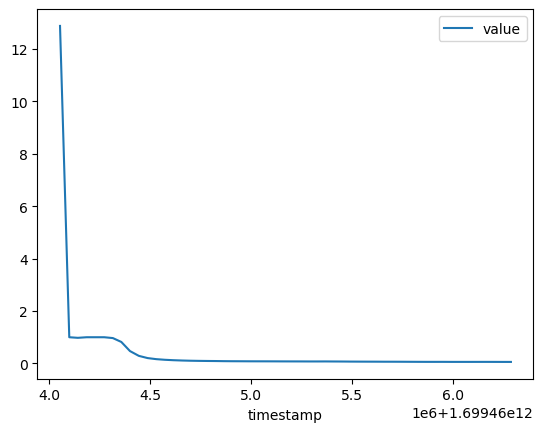

In [16]:
mllog[mllog["key"]=="eval_accuracy"][["timestamp", "value"]].plot(x="timestamp", y="value")